# Study of connectivity matrix
In this notebook we study the effects of the following parameters in the connectivity paramters:
* tau_z 
* tau_p
* training_time
* inter sequence interval time
* adaptation time
* tau_m (?)

In particular we are concerned about the following variables (in terms of the artificial matrix)
* Excitation
* Inhibition
* Extension
* Sequence Decay
* Extension Decay

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '61b730afc40a2a0933454b69ac8ca67b63ba95e7'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

In [3]:
from network import Protocol, BCPNNFast, NetworkManager
from plotting_functions import plot_weight_matrix
from analysis_functions import calculate_recall_success, calculate_timings

## A simple example

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 70
n_patterns = 60

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
simple_protocol = Protocol()
simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                inter_sequence_interval=inter_sequence_interval)

In [5]:
manager.run_network_protocol(simple_protocol)
w_small = manager.nn.w[:minicolumns, :minicolumns]

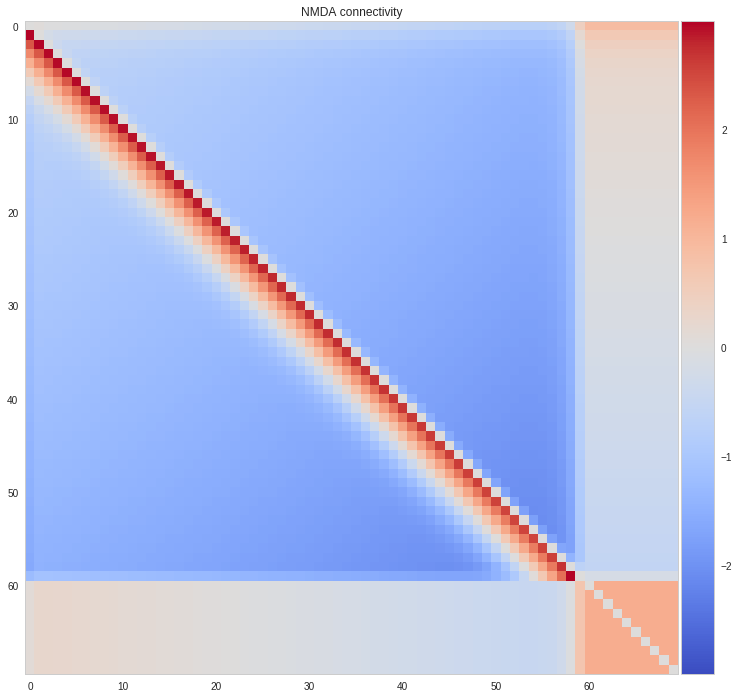

In [6]:
plot_weight_matrix(nn, one_hypercolum=True)

In [7]:
success = calculate_recall_success(manager, T_recall, I_cue=0, T_cue=T_cue, n=n, patterns_indexes=patterns_indexes)

In [8]:
timings = calculate_timings(manager)
for x in timings:
    print x[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


#### Now we need to define functions to calculate the desired quantities

In [9]:
print('success', success)

('success', 0.0)


First let's calculate intensity

In [10]:
next_connections = np.zeros(n_patterns - 1)
for i in range(n_patterns - 1):
    next_connections[i] =w_small[i + 1, i]

In [11]:
intensity = next_connections[0]
print(intensity)

2.9921054488


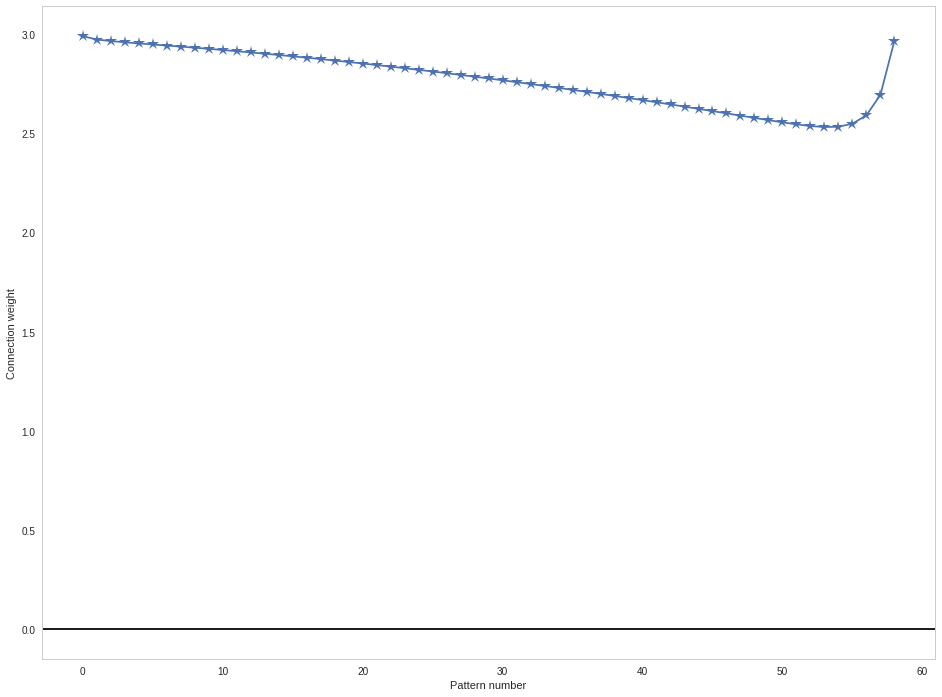

In [12]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(next_connections, '*-', markersize=13)
ax.axhline(0, color='k')

ax.set_xlabel('Pattern number')
ax.set_ylabel('Connection weight');


As we can see the weights that connect each element with its successor decay succesively. 

At the present moment **I do not know why this happens** it seems to be an ephiphenomena of the dynamics of the weights and p. As we can see both in the picture below both the peaks of p_co and p_i and p_j are very similar, however the phase at which we stop the training creates the differences in mangitude.

 ![p_dynamics](p_dyanmics2.png)

 ![caption](p_dynamics1.png)

Code to extract this from a simulation

```
pattern_1_from = 5
pattern_1_to =  6

pattern_2_from = 30
pattern_2_to = 31

p_pre = manager.history['p_pre']
p_post = manager.history['p_post']
p_co = manager.history['p_co']
w = manager.history['w']

p_pre_1 = p_pre[:, pattern_1_from]
p_post_1 = p_post[:, pattern_1_to]
p_co_1 = p_co[:, pattern_1_to, pattern_1_from]
w_1 = w[:, pattern_1_to, pattern_1_from]

p_pre_2 = p_pre[:, pattern_2_from]
p_post_2 = p_post[:, pattern_2_to]
p_co_2 = p_co[:, pattern_2_to, pattern_2_from]
w_2 = w[:, pattern_2_to, pattern_2_from]

# Plot the stuff
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(121)
ax.plot(p_pre_1 * p_post_1, label='1 p_i * p_j')
ax.plot(p_co_1, label='1 co')

ax.plot(p_pre_2 * p_post_2, label='2 p_i * p_j')
ax.plot(p_co_2, label='2 co')

ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(p_co_1 / (p_pre_1 * p_post_1), label='w 1')
ax2.plot(p_co_2 / (p_pre_2 * p_post_2), label='w 2')

ax2.legend()
plt.show()

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(w_1, label='w_1')
ax.plot(w_2, label='w_2')

ax.legend()
ax.plot()
```

Let's calculate the ratios between them

In [13]:
sequence_ratios = np.zeros(n_patterns - 2)
for i in range(n_patterns - 2):
    sequence_ratios[i] = next_connections[i + 1] / next_connections[i]

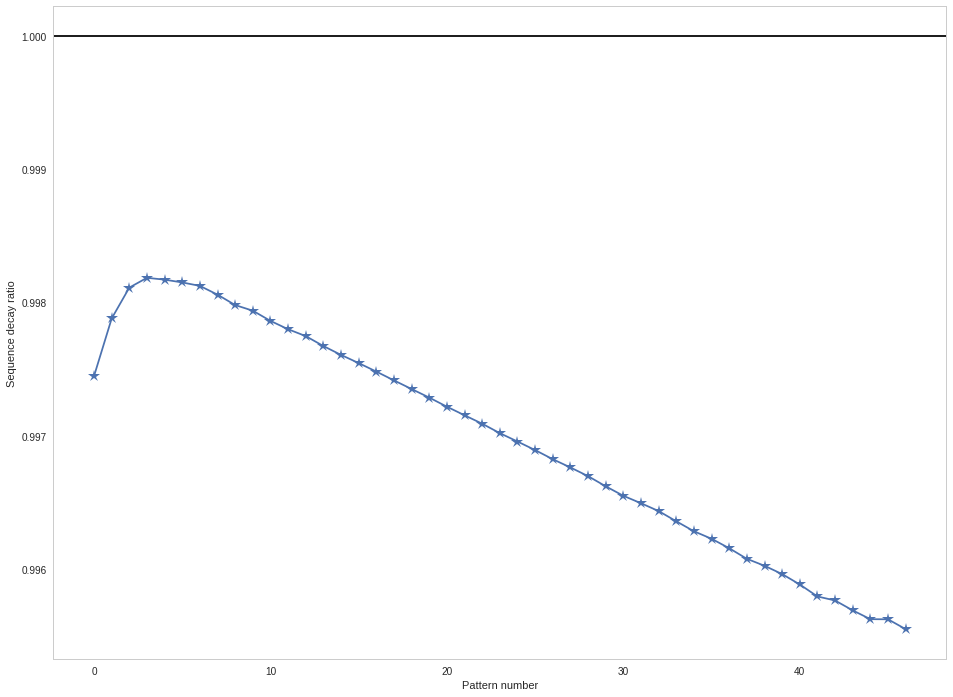

In [14]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sequence_ratios[1:-10], '*-', markersize=13)
ax.axhline(1, color='k')

ax.set_xlabel('Pattern number')
ax.set_ylabel('Sequence decay ratio');

We can see the ratio is a little bit below 0.9. What we will do here is remove the first and the last five values and calculate the mean

In [15]:
sequence_decay = np.mean(sequence_ratios[1:-5])
print(sequence_decay)

0.996916006058


Let's pack this into a function

In [16]:
def calculate_intensity_and_decay(w_small):
    next_connections = np.zeros(n_patterns - 1)
    for i in range(n_patterns - 1):
        next_connections[i] =w_small[i + 1, i]
        
    intensity = next_connections[0]
    
    sequence_ratios = np.zeros(n_patterns - 2)
    for i in range(n_patterns - 2):
        sequence_ratios[i] = next_connections[i + 1] / next_connections[i]
        
    sequence_decay = np.mean(sequence_ratios[1:-5])
    
    return intensity, sequence_decay

In [17]:
intensity, sequence_decay = calculate_intensity_and_decay(w_small)
print(sequence_decay)
print(intensity)

0.996916006058
2.9921054488


Now let's calculate the extensions

In [18]:
extensions = []
weights = []
extensions_decay = []
tolerance = 5
total = n_patterns - 5
for i in range(tolerance, total):
    w_column = w_small[:n_patterns, i]
    w_column = w_column[w_column > 0]
    ratios = w_column[1:] / w_column[:-1]
    extensions_decay.append(np.mean(ratios))
    extensions.append(w_column.size)
    for w in w_column:
        weights.append(w)        

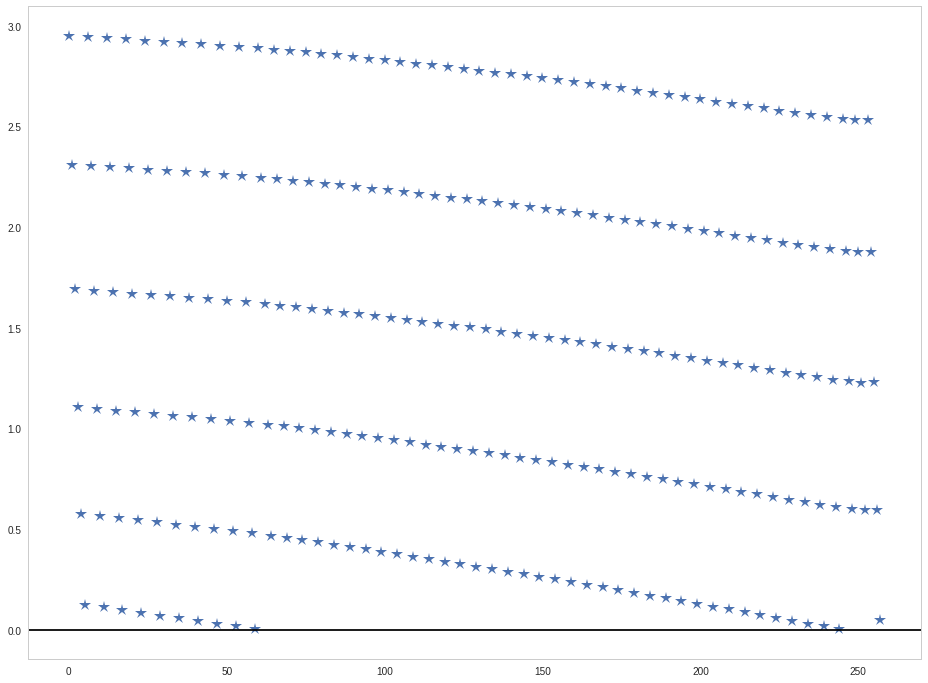

In [19]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(weights, '*', markersize=13);
ax.axhline(0, color='black')

We see here the connections between each of the patterns and moreover the weak connections that cover the next patterns on the go.

In [20]:
extension_decay = np.median(extensions_decay)
print(extension_decay)

0.571751272571


In [21]:
extension = int(np.median(extensions))
print(extension)

5


Now we pack this into a function

In [22]:
def calculate_extensions(w_small, tolerance):
    extensions = []
    extensions_decay = []
    total = n_patterns - tolerance
    for i in range(tolerance, total):
        w_column = w_small[:n_patterns, i]
        w_column = w_column[w_column > 0]
        ratios = w_column[1:] / w_column[:-1]
        extensions_decay.append(np.mean(ratios))
        extensions.append(w_column.size)
    
    extension_decay = np.median(extensions_decay)
    extension = int(np.median(extensions))
    
    return extension, extension_decay

In [23]:
extension, extension_decay = calculate_extensions(w_small, tolerance=5)
print('extension', extension)
print('extension decay', extension_decay)

('extension', 5)
('extension decay', 0.57175127257121605)


Finally we need inhibition

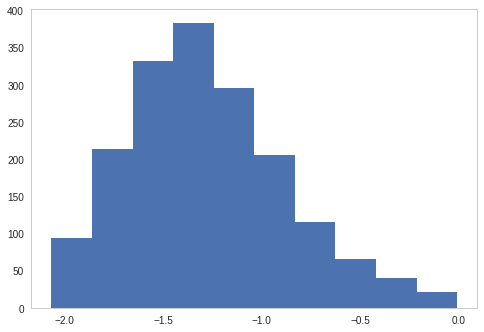

In [24]:
upper_indices = np.triu_indices(n_patterns)
w_upper = w_small[upper_indices]
w_upper = w_upper[w_upper < 0]
plt.hist(w_upper);

In [25]:
def calculate_inhibition(w_small):
    upper_indices = np.triu_indices(n_patterns)
    w_upper = w_small[upper_indices]
    w_upper = w_upper[w_upper < 0]
    
    mean = np.mean(w_upper)
    std = np.std(w_upper)
    
    return mean, std

In [26]:
mean, std = calculate_inhibition(w_small)
print('mean inhibition', mean)
print('std', std)

('mean inhibition', -1.2756948293794725)
('std', 0.40104334878810027)


## Training time
Let's calculate the dependence on this parameter

In [27]:
tolerance = 5

In [28]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

training_times_vector = np.arange(0.100, 2.100, 0.100)

In [29]:
def store_values(intensities, intensity, decays, decay, extensions, extension,
                 extension_decays, extension_decay, inhibitions, inhibition, inhibitions_std, inhibition_std):
    
    intensities.append(intensity)
    decays.append(decay)
    extensions.append(extension)
    extension_decays.append(extension_decay)
    inhibitions.append(inhibition)
    inhibitions_std.append(inhibition_std)
    

In [30]:
training_time_intensity = []
training_time_decay = []
training_time_extension = []
training_time_extension_decay = []
training_time_inhibition = []
training_time_inhibition_std = []

for training_times in training_times_vector:
    print(training_times)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(training_time_intensity, intensity, training_time_decay, sequence_decay, training_time_extension, 
                 extension, training_time_extension_decay, extension_decay, training_time_inhibition, inhibition,
                 training_time_inhibition_std, inhibition_std)
    

0.1
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.2
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.3
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.4


/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


('epochs', 0)
('epochs', 1)
('epochs', 2)
0.5
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.6
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.7
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.8
('epochs', 0)
('epochs', 1)
('epochs', 2)
0.9
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.0
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.1
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.2
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.3
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.4
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.5
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.6
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.7
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.8
('epochs', 0)
('epochs', 1)
('epochs', 2)
1.9
('epochs', 0)
('epochs', 1)
('epochs', 2)
2.0
('epochs', 0)
('epochs', 1)
('epochs', 2)


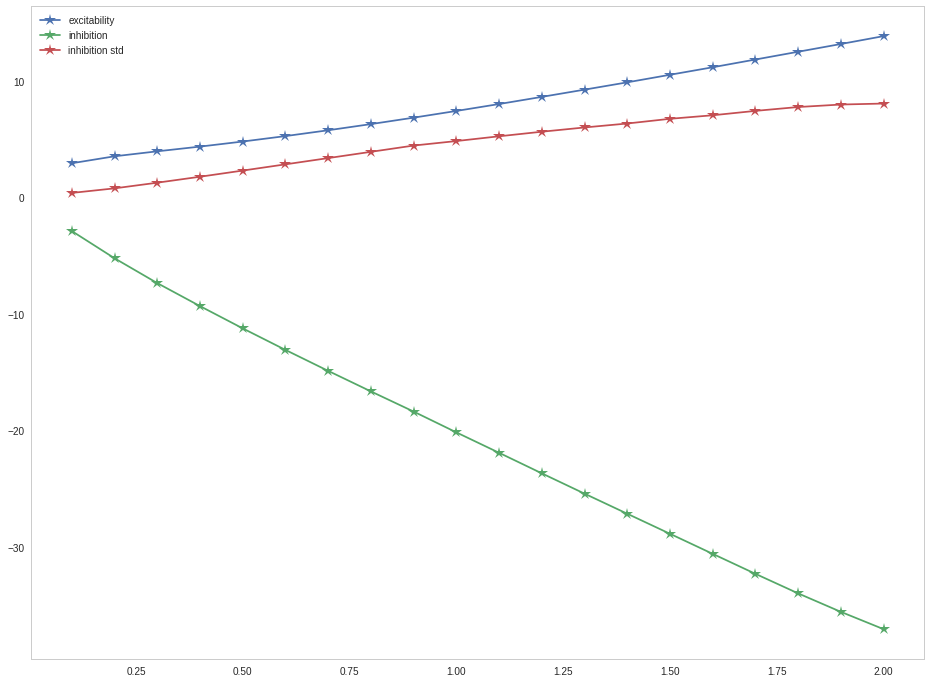

In [31]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_times_vector, training_time_intensity, '*-', markersize=13, label='excitability')
ax.plot(training_times_vector, training_time_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(training_times_vector, training_time_inhibition_std, '*-', markersize=13, label='inhibition std')

ax.legend();

It makes sense that the more time that we expect training the pattern the higher the connectivity (more evidence is collected in the Bayesian sense), same thing for the inhbition (evidence that the patterns are not together). The itneresting thing here is the apprent fact that the inhibition grows faster and the the standar deviation of the inhibition distribution becomes wider.

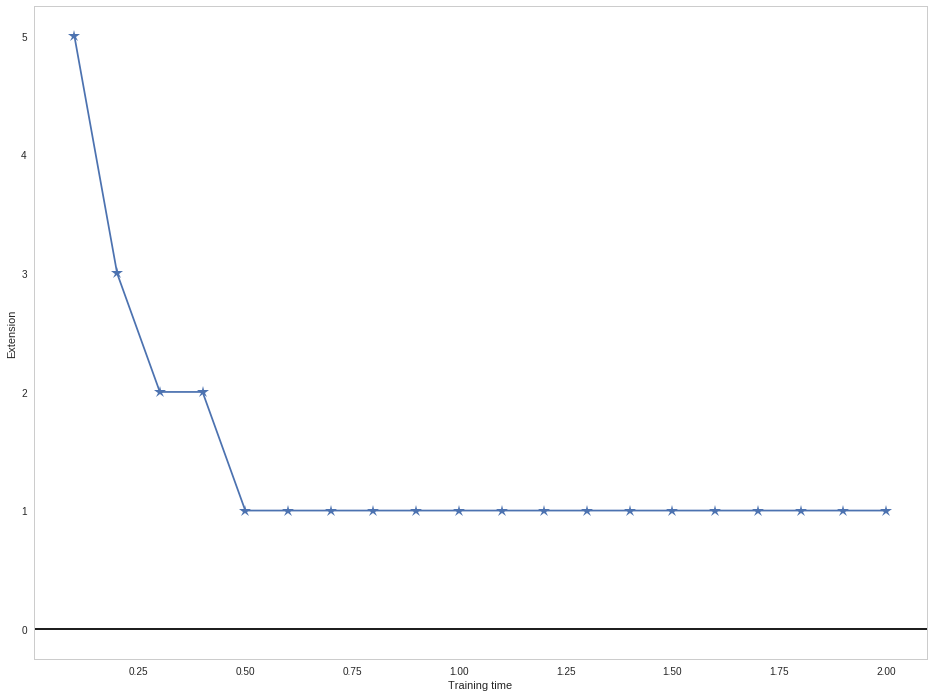

In [32]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_times_vector, training_time_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')

ax.set_ylabel('Extension')
ax.set_xlabel('Training time');

Why should the extension decrease? because if the patterns lasts too long the **temporal memory** given by tau_z does not last long enough to bind the elements.

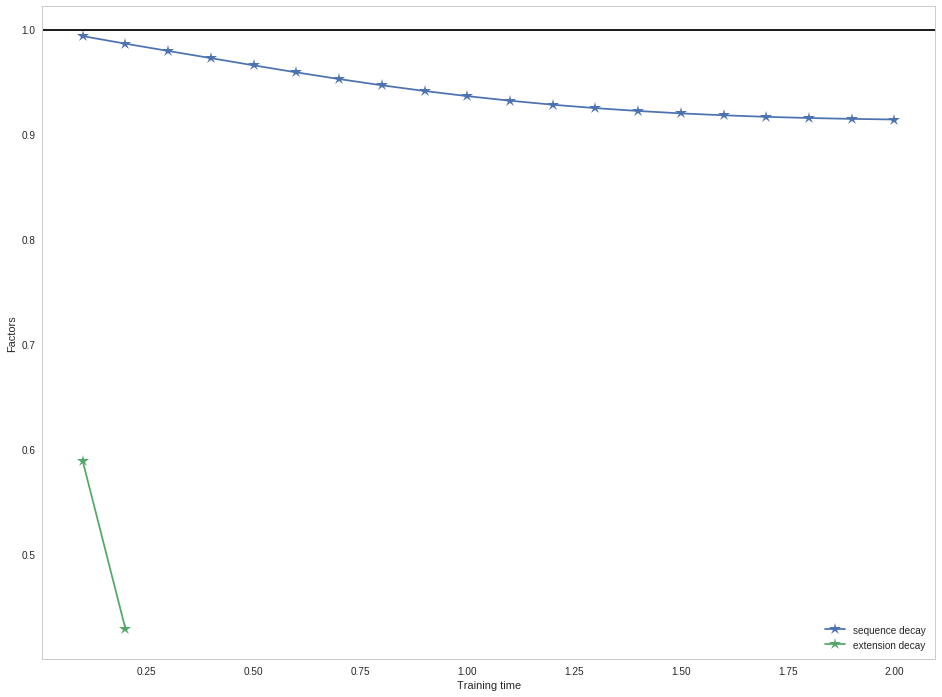

In [33]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_times_vector, training_time_decay, '*-', markersize=13, label='sequence decay')
ax.plot(training_times_vector, training_time_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')
ax.set_xlabel('Training time')
ax.set_ylabel('Factors')
ax.legend();

I do not understand the sequence decay here. Why it does increase with the training time? 

I suspect the following: if we go back to the pictures of the p dynamics above we can conjecture that the higher the training time the higher the peaks in the probabiltiies and therefore the more time they need to decay.

 

## Inter sequence time

In [34]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

inter_sequence_interval_vector = np.arange(0, 3.5, 0.5)

In [35]:
inter_sequence_intensity = []
inter_sequence_decay = []
inter_sequence_extension = []
inter_sequence_extension_decay = []
inter_sequence_inhibition = []
inter_sequence_inhibition_std = []

for inter_sequence_interval in inter_sequence_interval_vector:
    print(inter_sequence_interval)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(inter_sequence_intensity, intensity, inter_sequence_decay, sequence_decay, inter_sequence_extension, 
                 extension, inter_sequence_extension_decay, extension_decay, inter_sequence_inhibition, inhibition,
                 inter_sequence_inhibition_std, inhibition_std)
    

0.0
0.5
1.0
1.5
2.0
2.5
3.0


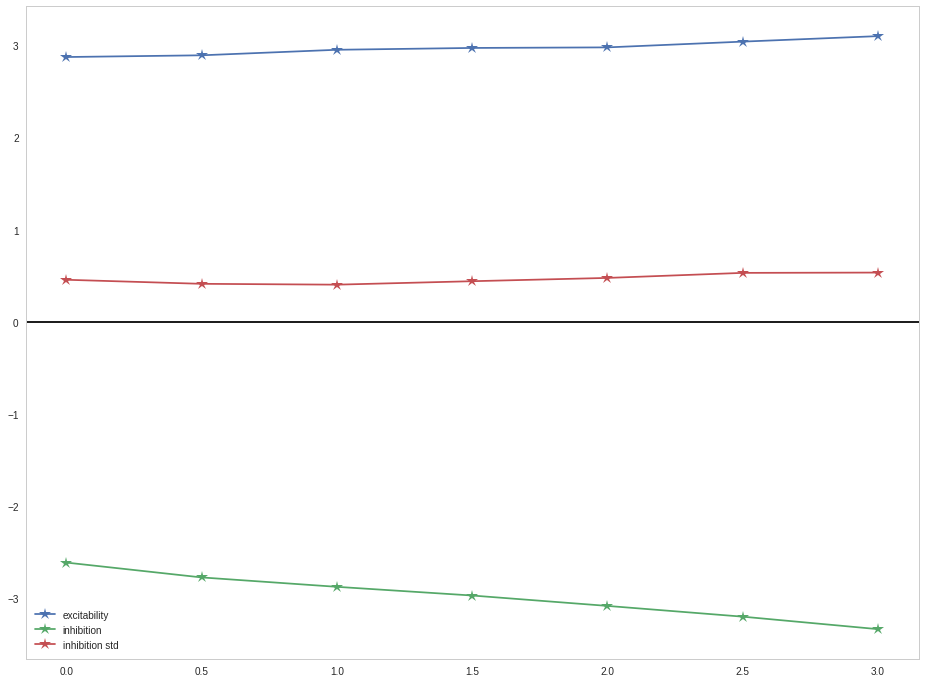

In [36]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_intensity, '*-', markersize=13, label='excitability')
ax.plot(inter_sequence_interval_vector, inter_sequence_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(inter_sequence_interval_vector, inter_sequence_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

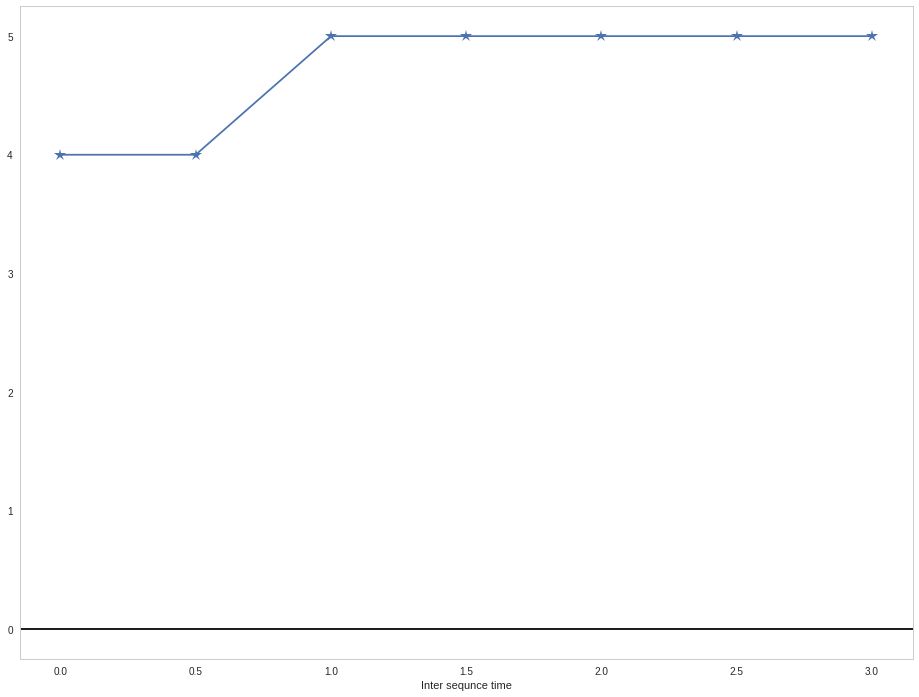

In [37]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')
ax.set_xlabel('Inter sequnce time');

This is **interesting** why?

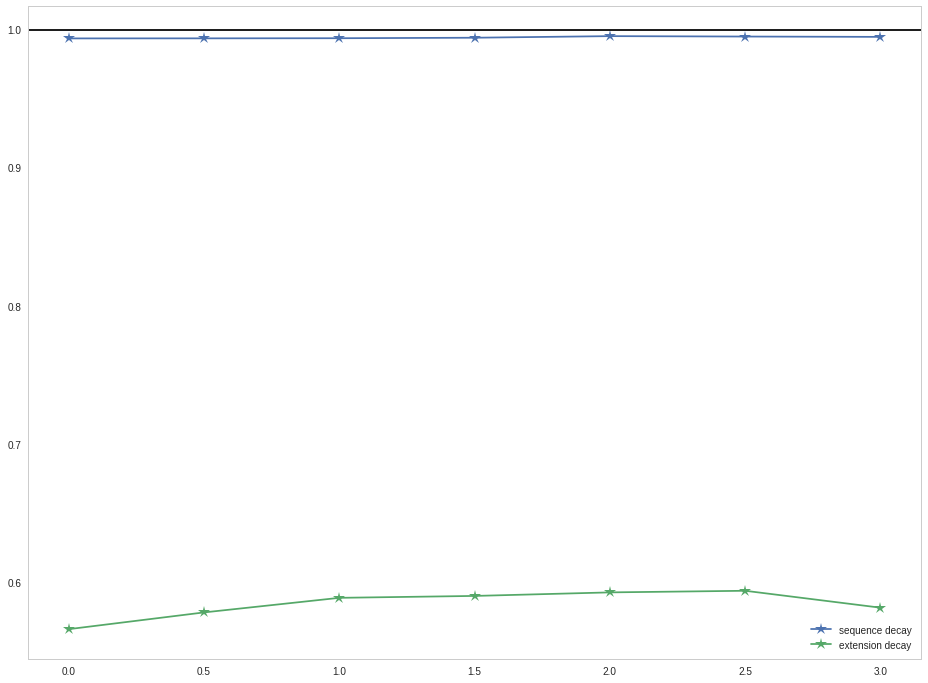

In [38]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_vector, inter_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(inter_sequence_interval_vector, inter_sequence_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')
ax.legend();

## Epoch

In [39]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

epochs_vector = np.arange(1, 10, 1, dtype='int')

In [40]:
epochs_intensity = []
epochs_sequence_decay = []
epochs_extension = []
epochs_extension_decay = []
epochs_inhibition = []
epochs_inhibition_std = []

for epochs in epochs_vector:
    print(epochs)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(epochs_intensity, intensity, epochs_sequence_decay, sequence_decay, epochs_extension, 
                 extension, epochs_extension_decay, extension_decay, epochs_inhibition, inhibition,
                 epochs_inhibition_std, inhibition_std)
    

1
2
3
4
5
6
7
8
9


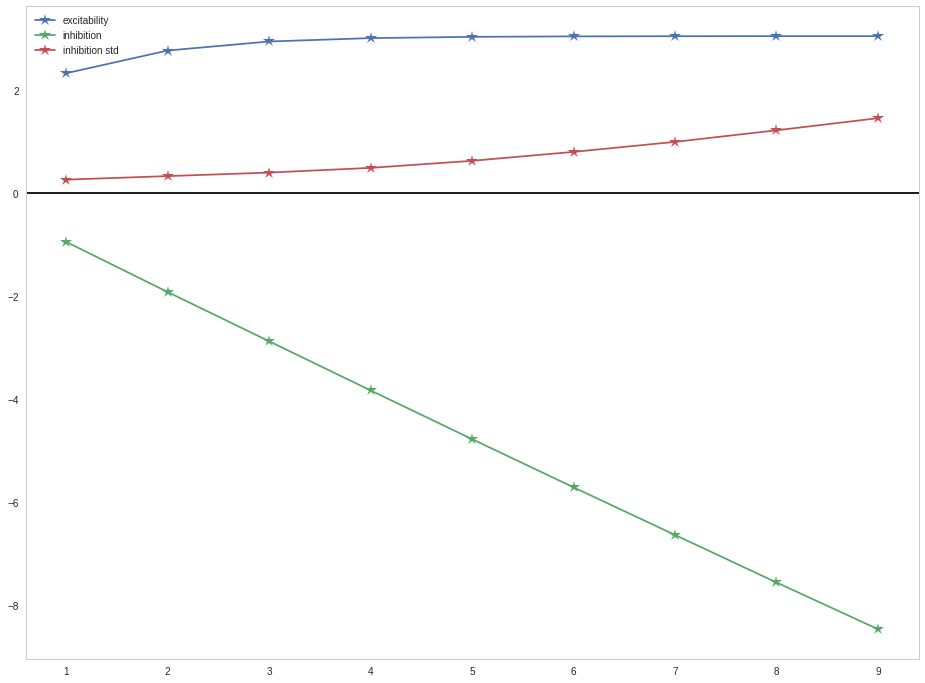

In [41]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_vector, epochs_intensity, '*-', markersize=13, label='excitability')
ax.plot(epochs_vector, epochs_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(epochs_vector, epochs_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

It is interesting that only inhibition grows with epochs, why this could be? I think it is because of the patterns that were never activated. They keep acumulating negative evidence the more they remain active together, in the case of the positive ones they oscillate around the mid-point (and the value we see here) between activiation and deactivation. 

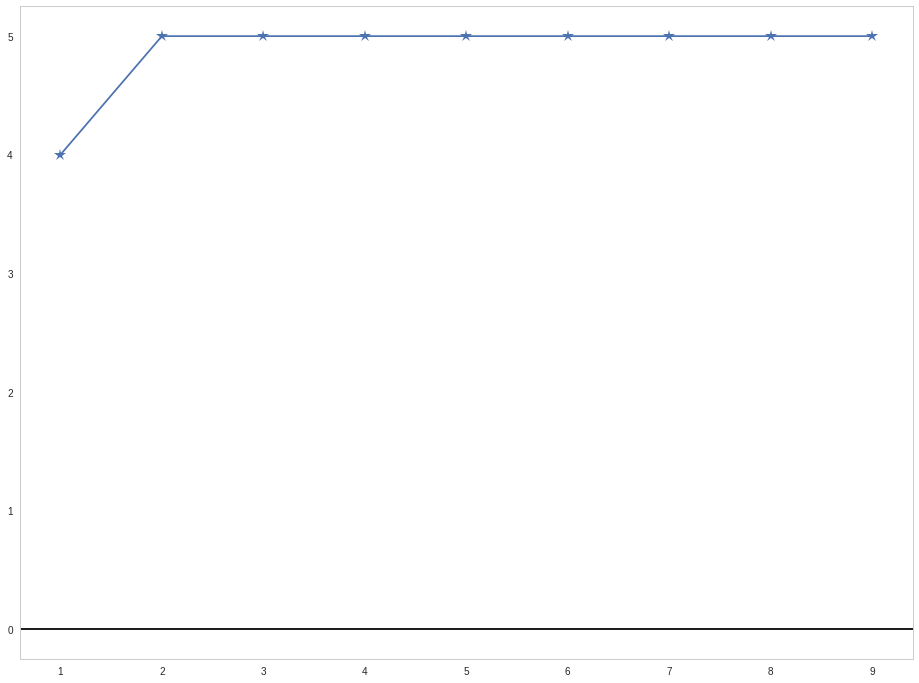

In [42]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_vector, epochs_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k');

Why extension grows with epochs? as usual, there seems to be some weird instabilities with low epochs, after three it basically stabilizes itself.

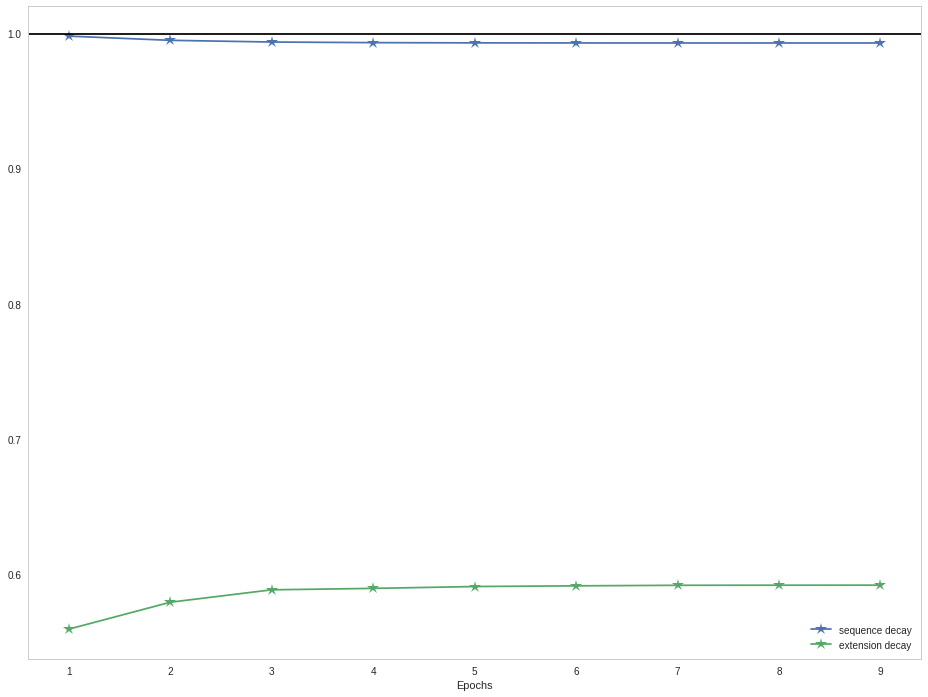

In [43]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_vector, epochs_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(epochs_vector, epochs_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')
ax.set_xlabel('Epochs')
ax.legend();

## tau_z

In [44]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_z_pre_vector = np.arange(0.050, 0.550,0.050)

In [45]:
tau_z_intensity = []
tau_z_sequence_decay = []
tau_z_extension = []
tau_z_extension_decay = []
tau_z_inhibition = []
tau_z_inhibition_std = []

for tau_z_pre in tau_z_pre_vector:
    print(tau_z_pre)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(tau_z_intensity, intensity, tau_z_sequence_decay, sequence_decay, tau_z_extension, 
                 extension, tau_z_extension_decay, extension_decay, tau_z_inhibition, inhibition,
                 tau_z_inhibition_std, inhibition_std)
    

0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5


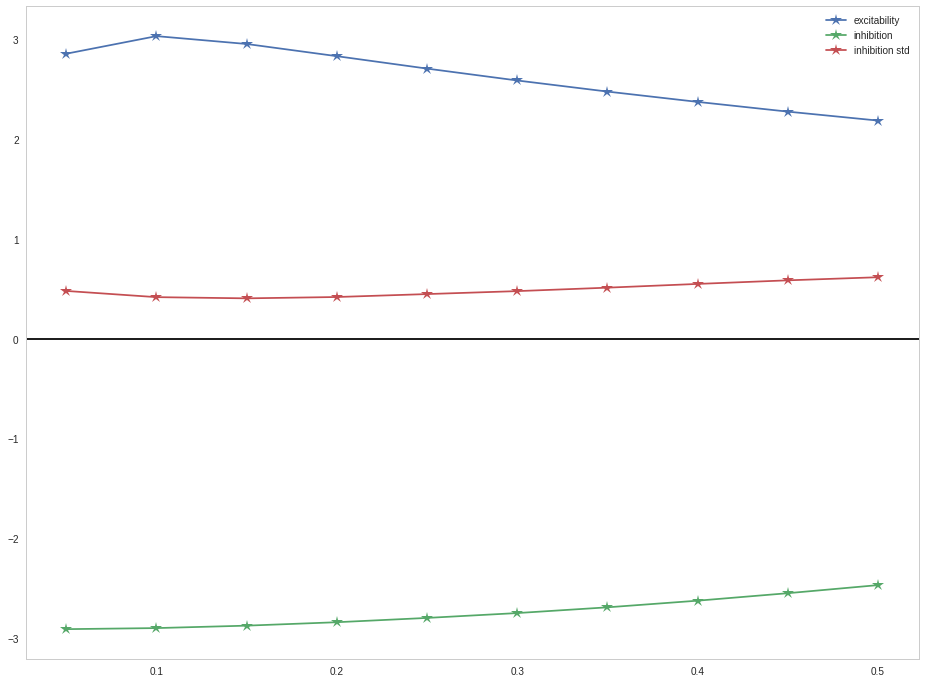

In [46]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, tau_z_intensity, '*-', markersize=13, label='excitability')
ax.plot(tau_z_pre_vector, tau_z_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(tau_z_pre_vector, tau_z_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

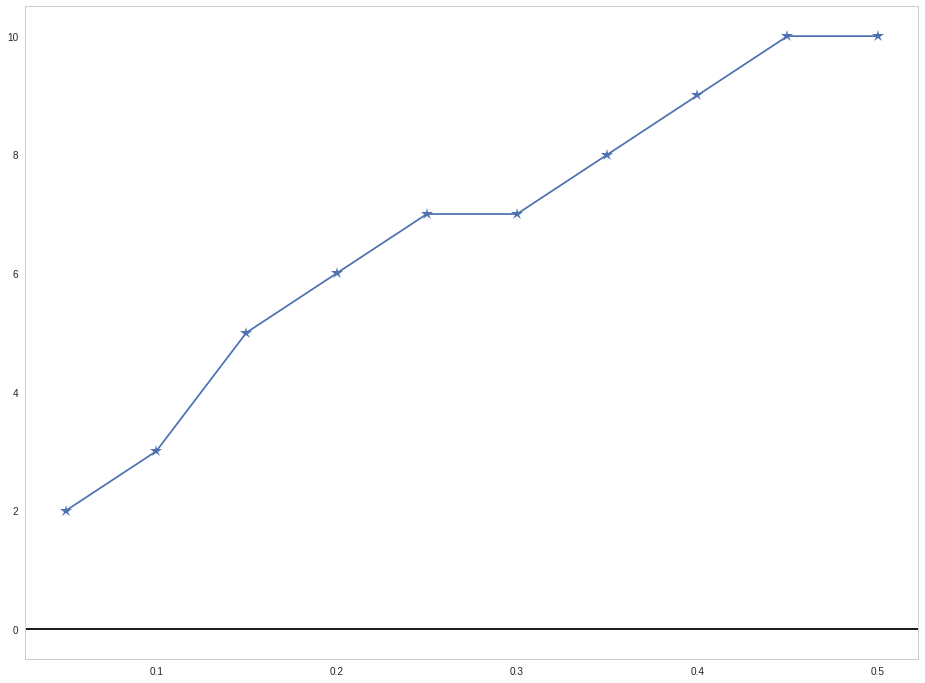

In [47]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, tau_z_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k');

As expected the extension increases with tau_z

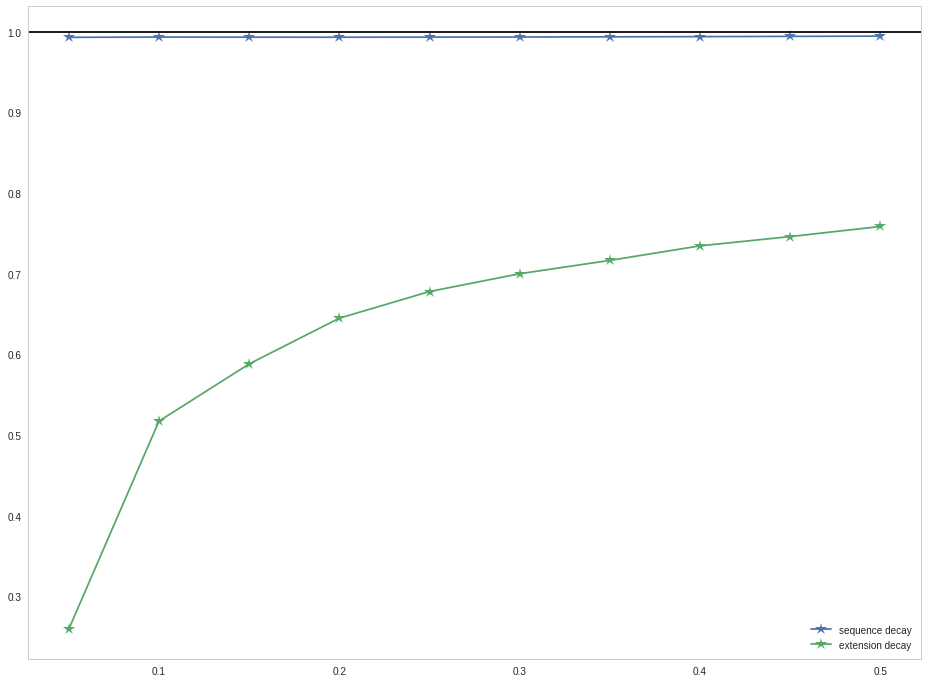

In [48]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_pre_vector, tau_z_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(tau_z_pre_vector, tau_z_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

The extenion decays values make sense, the longer the tau_z the less it decays (value close to 1).

## tau_p

In [49]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_p_vector = np.arange(0.1, 10.1, 0.5)

In [50]:
tau_p_intensity = []
tau_p_sequence_decay = []
tau_p_extension = []
tau_p_extension_decay = []
tau_p_inhibition = []
tau_p_inhibition_std = []

for tau_p in tau_p_vector:
    print(tau_p)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre, tau_p=tau_p)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(tau_p_intensity, intensity, tau_p_sequence_decay, sequence_decay, tau_p_extension, 
                 extension, tau_p_extension_decay, extension_decay, tau_p_inhibition, inhibition,
                 tau_p_inhibition_std, inhibition_std)
    

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1
9.6


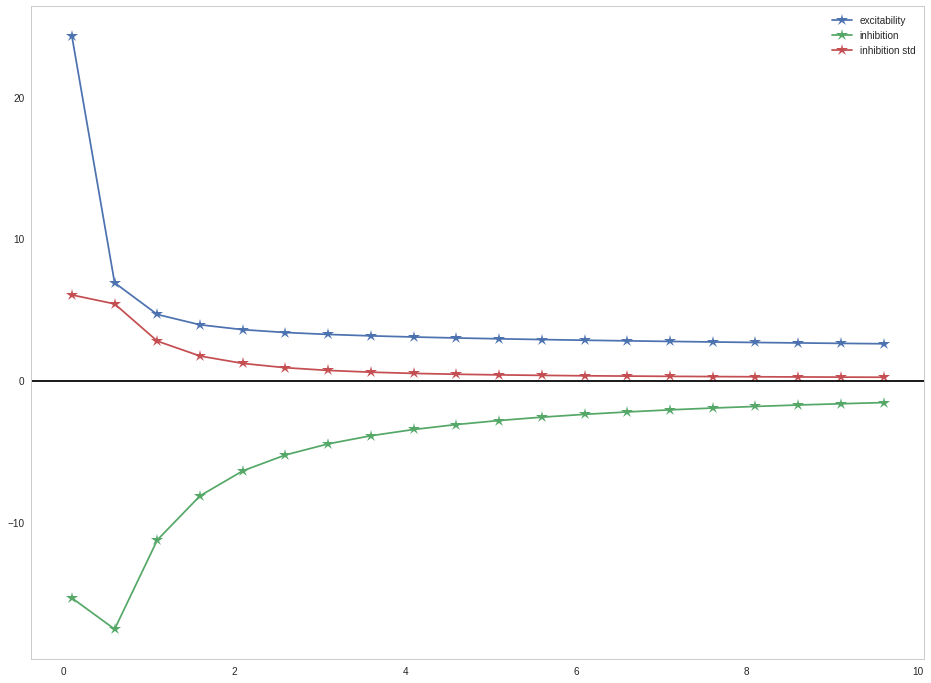

In [51]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_p_vector, tau_p_intensity, '*-', markersize=13, label='excitability')
ax.plot(tau_p_vector, tau_p_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(tau_p_vector, tau_p_inhibition_std, '*-', markersize=13, label='inhibition std')
ax.axhline(0, color='k')

ax.legend();

I expect that after certain value the values do not matter that much. Probably if a lot of patterns are stored then there will be problems with the convergence (the system will forgert most of them)

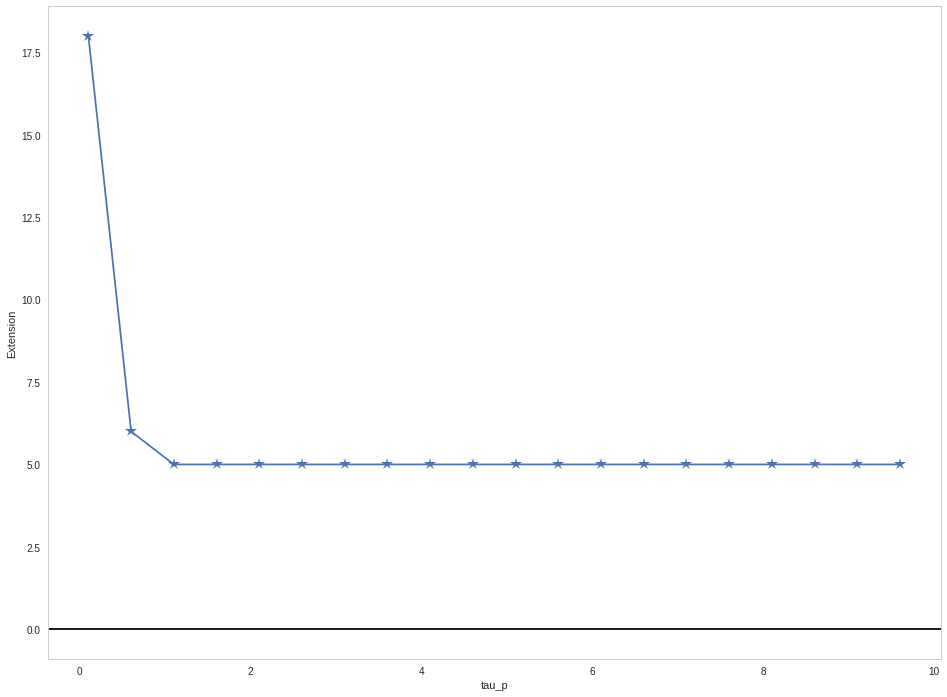

In [52]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_p_vector, tau_p_extension, '*-', markersize=13, label='extension')

ax.set_xlabel('tau_p')
ax.set_ylabel('Extension')

ax.axhline(0, color='k');

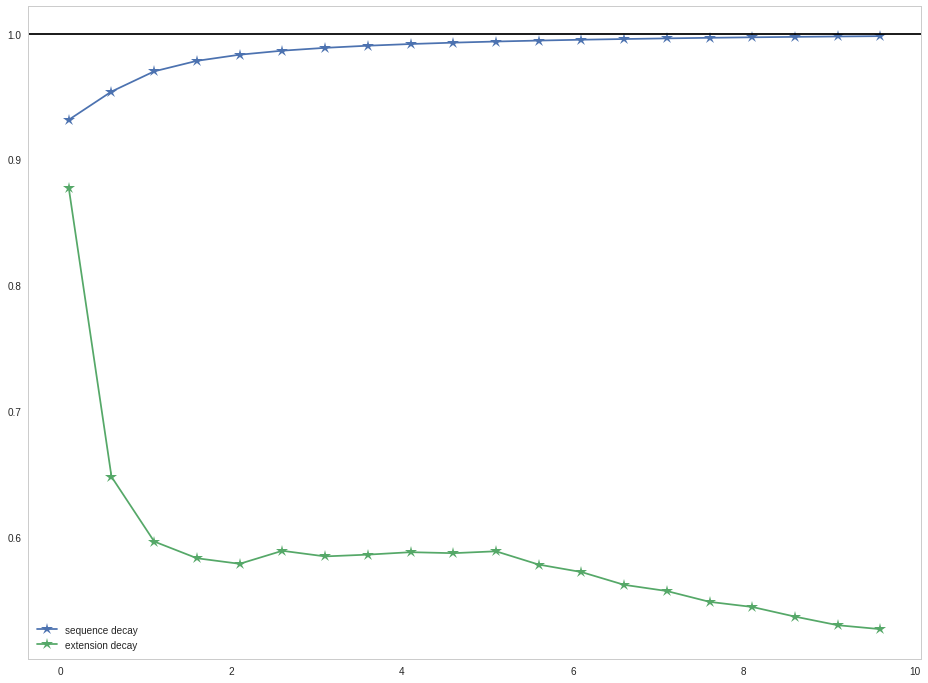

In [53]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_p_vector, tau_p_sequence_decay, '*-', markersize=13, label='sequence decay')
ax.plot(tau_p_vector, tau_p_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

## Tau_a

In [54]:
tolerance = 5

In [55]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

patterns_indexes = [i for i in range(n_patterns)]

tau_a_vector = np.arange(1.0, 5.5, 0.500)

In [56]:
tau_a_intensity = []
tau_a_decay = []
tau_a_extension = []
tau_a_extension_decay = []
tau_a_inhibition = []
tau_a_inhibition_std = []

for tau_a in tau_a_vector:
    print(tau_a)
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre, tau_a=tau_a)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(tau_a_intensity, intensity, tau_a_decay, sequence_decay, tau_a_extension, 
                 extension, tau_a_extension_decay, extension_decay, tau_a_inhibition, inhibition,
                 tau_a_inhibition_std, inhibition_std)
    

1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


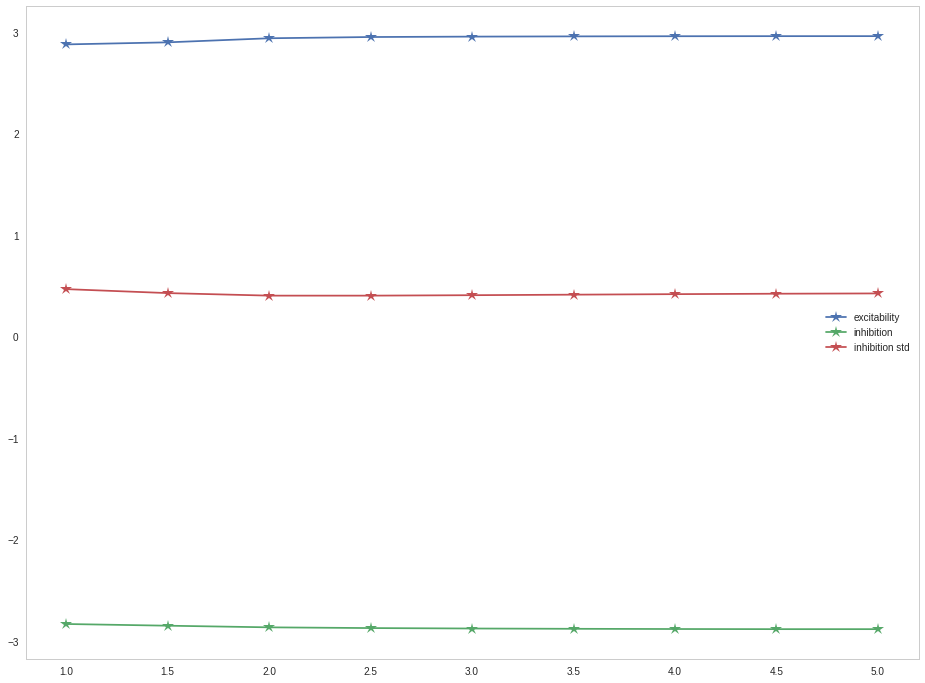

In [57]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_vector, tau_a_intensity, '*-', markersize=13, label='excitability')
ax.plot(tau_a_vector, tau_a_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(tau_a_vector, tau_a_inhibition_std, '*-', markersize=13, label='inhibition std')

ax.legend();

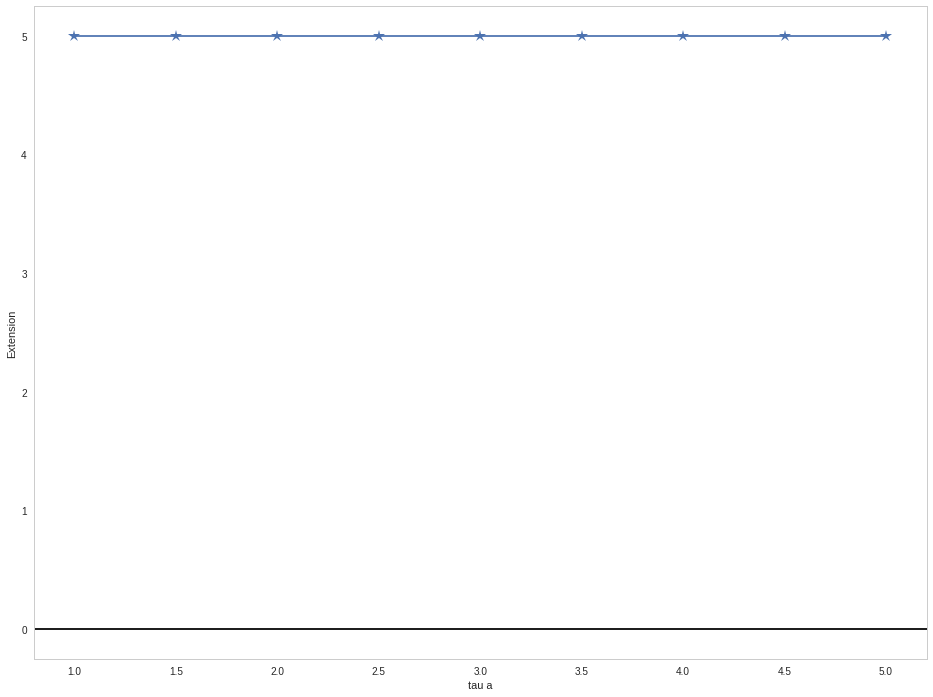

In [58]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_vector, tau_a_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')

ax.set_xlabel('tau a')
ax.set_ylabel('Extension');

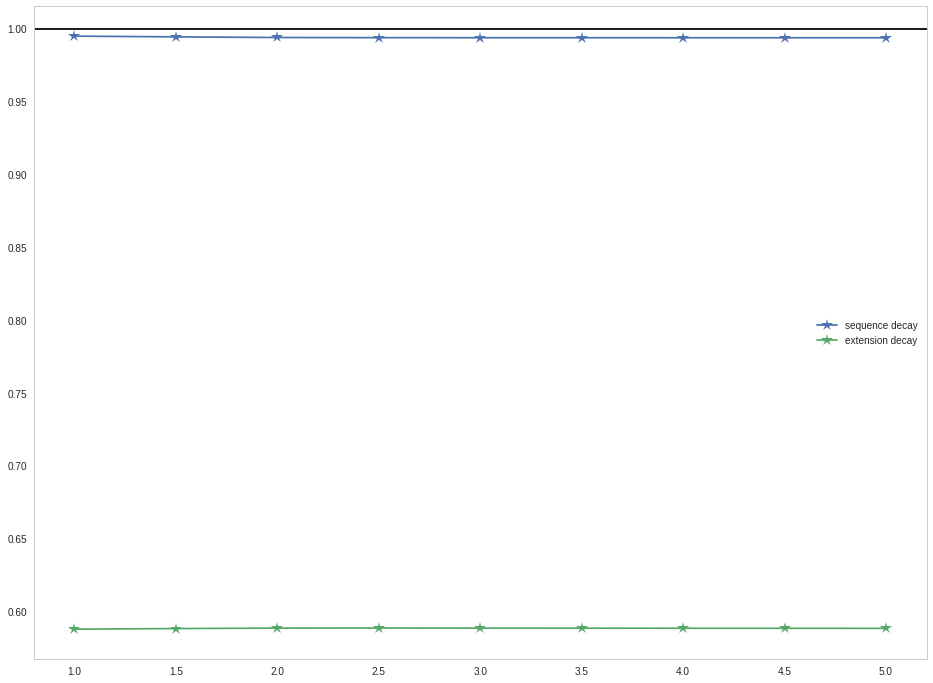

In [59]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_a_vector, tau_a_decay, '*-', markersize=13, label='sequence decay')
ax.plot(tau_a_vector, tau_a_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.legend();

## Numbef of patterns

In [60]:
tolerance = 5

In [61]:
# Patterns parameters
hypercolumns = 4
minicolumns = 100
n_patterns = 40

dt = 0.001

# Timings parameters
tau_z_pre = 0.150
tau_a = 2.7
tau_p = 5.0
epochs = 3

# Traiming parameters
training_times = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0

n = 5
T_cue = 0.100
T_recall = 10.0

n_patterns_vector = np.arange(15, 85, 5)

In [62]:
n_patterns_intensity = []
n_patterns_decay = []
n_patterns_extension = []
n_patterns_extension_decay = []
n_patterns_inhibition = []
n_patterns_inhibition_std = []

for n_patterns in n_patterns_vector:
    print(n_patterns)
    patterns_indexes = [i for i in range(n_patterns)]
    nn = BCPNNFast(hypercolumns=hypercolumns, minicolumns=minicolumns, tau_z_pre=tau_z_pre, tau_a=tau_a)
    manager = NetworkManager(nn, dt=dt, values_to_save=['o'])
    simple_protocol = Protocol()
    simple_protocol.simple_protocol(patterns_indexes=patterns_indexes, training_time=training_times,
                                    inter_sequence_interval=inter_sequence_interval, epochs=epochs)
    
    manager.run_network_protocol(simple_protocol, verbose=False)
    w_small = manager.nn.w[:minicolumns, :minicolumns]
    
    intensity, sequence_decay = calculate_intensity_and_decay(w_small)
    extension, extension_decay = calculate_extensions(w_small, tolerance=tolerance)
    inhibition, inhibition_std = calculate_inhibition(w_small)
    
    
    store_values(n_patterns_intensity, intensity, n_patterns_decay, sequence_decay, n_patterns_extension, 
                 extension, n_patterns_extension_decay, extension_decay, n_patterns_inhibition, inhibition,
                 n_patterns_inhibition_std, inhibition_std)
    

15
20
25
30
35
40
45
50
55
60
65
70
75
80


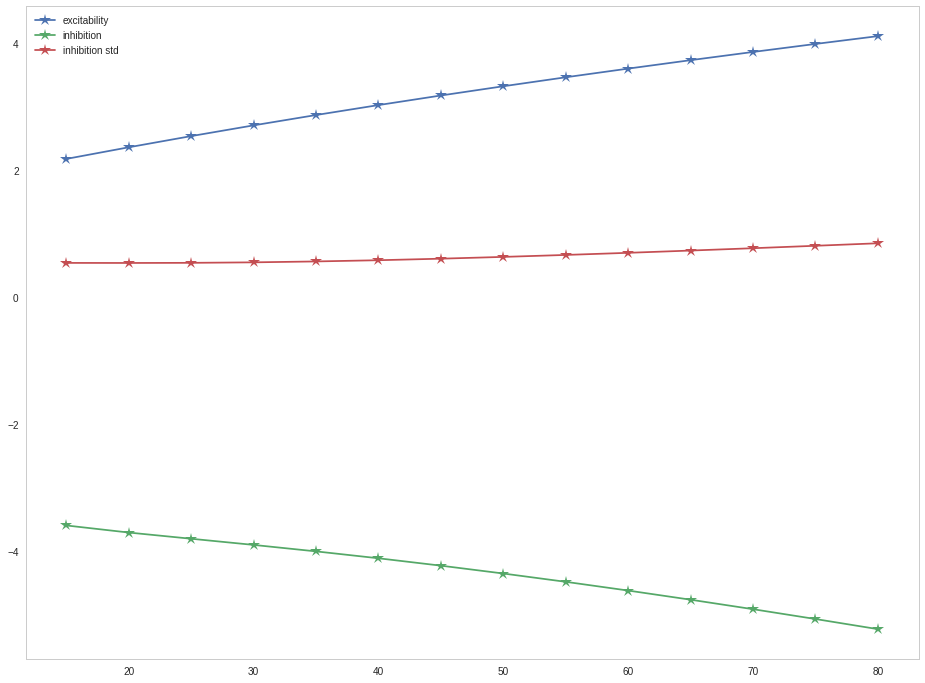

In [63]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_vector, n_patterns_intensity, '*-', markersize=13, label='excitability')
ax.plot(n_patterns_vector, n_patterns_inhibition, '*-', markersize=13, label='inhibition')
ax.plot(n_patterns_vector, n_patterns_inhibition_std, '*-', markersize=13, label='inhibition std')

ax.legend();

In a way it is interesting that the excitability grows with the number of patterns, but after we consider that this just agregates Bayesian evidence activity coincidence in a bigger space should be weighted higher. 

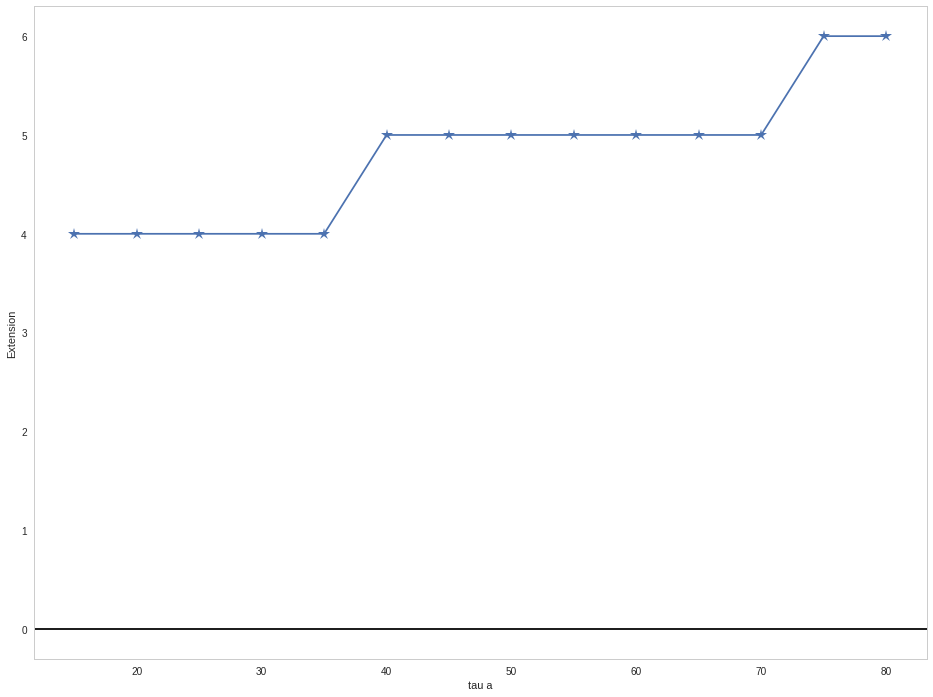

In [64]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_vector, n_patterns_extension, '*-', markersize=13, label='extension')

ax.axhline(0, color='k')

ax.set_xlabel('N patterns')
ax.set_ylabel('Extension');

The fact that the extension is bigger is actually a big suprise, why this can be?

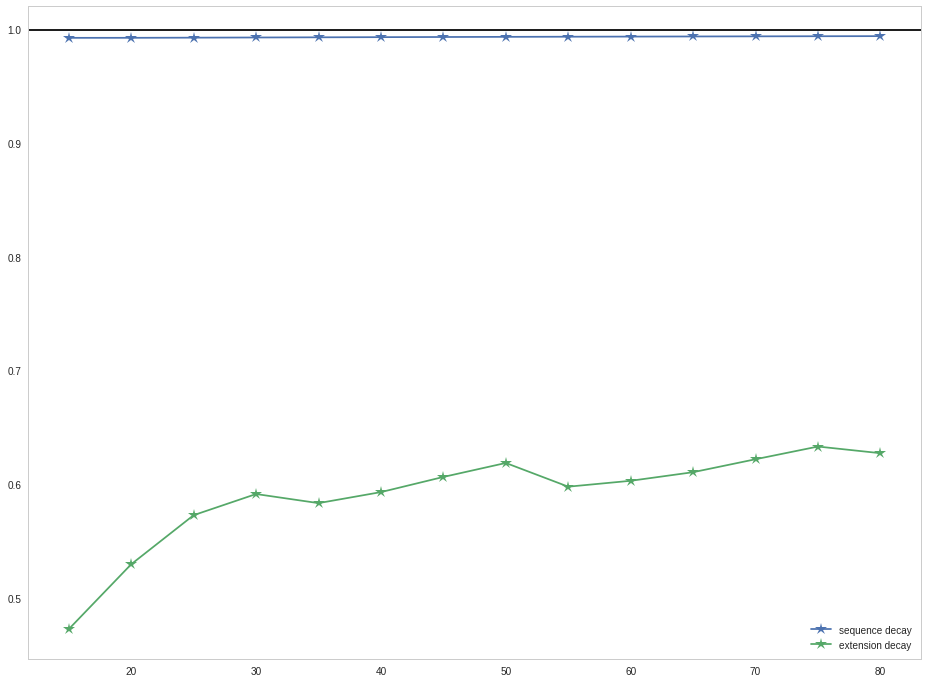

In [65]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_vector, n_patterns_decay, '*-', markersize=13, label='sequence decay')
ax.plot(n_patterns_vector, n_patterns_extension_decay, '*-', markersize=13, label='extension decay')

ax.axhline(1.0, color='black')

ax.set_xlabel('N patterns')
ax.set_ylabel('Extension');
ax.legend();

### Git machinery

In [66]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])